# Machine Learning Regression

- José Luis Narváez Bolaños
- Wilmer Hernandez

In [1]:
import os, sys
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_gbq
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

from pandas_profiling import ProfileReport

from pathlib import Path

In [2]:
#Define the paths of the directories
current_dir=Path('.').resolve()
#Returns to the directory’s parent folder
project_dir=Path(current_dir).parent
print(current_dir)
print(project_dir)

/home/jupyter/ESEIT_BigData/notebooks
/home/jupyter/ESEIT_BigData


In [3]:
file_data=os.path.join(project_dir,"data","raw","Housing.csv")
data=pd.read_csv(file_data)
data

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


# Exploratory Data Analysis (EDA)

In [4]:
report=ProfileReport(df=data,minimal=True)
report

Summarize dataset:   0%|          | 0/21 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
target='price'

num_cols=['area']
ord_cols=['bedrooms','bathrooms','stories']
cat_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea', 'furnishingstatus']

<AxesSubplot:xlabel='area', ylabel='price'>

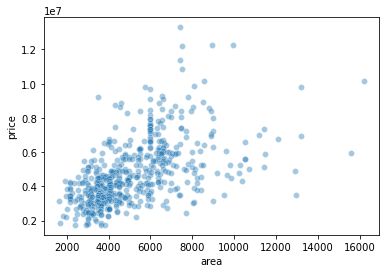

In [6]:
sns.scatterplot(x='area',y='price',data=data,alpha=0.4)

# Feature Engineering

- Converting Numeric cols to categorical cols
- New variables
- One-hot encoder

In [7]:
data['area'].quantile([0.20,0.4,0.6,0.8])

0.2    3450.0
0.4    4065.0
0.6    5400.0
0.8    6600.0
Name: area, dtype: float64

In [8]:
data['area_cat']=pd.cut(data['area'],
                        bins=[0.,3450,4065,5400,6600,np.inf],
                        labels=[1,2,3,4,5])
data['area_cat'].value_counts()

1    112
3    112
5    108
4    107
2    106
Name: area_cat, dtype: int64

<AxesSubplot:xlabel='area_cat', ylabel='price'>

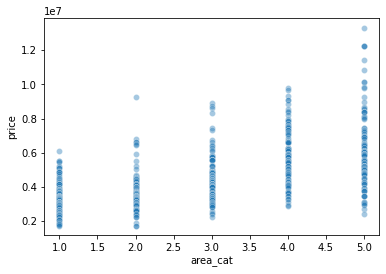

In [9]:
sns.scatterplot(x='area_cat',y='price',data=data,alpha=0.4)

<AxesSubplot:>

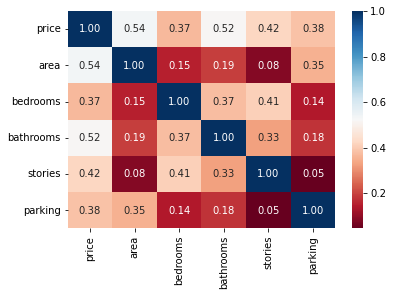

In [10]:
corr_matrix=data.corr()
corr_matrix
sns.heatmap(corr_matrix, cmap='RdBu', annot=True, fmt=".2f")
#corr_matrix['price'].sort_values(ascending=False)

# One-Hot Encoder

In [11]:
data_dummies=pd.get_dummies(data[cat_cols])
data_dummies.head()

,parking,mainroad_no,mainroad_yes,guestroom_no,guestroom_yes,basement_no,basement_yes,hotwaterheating_no,hotwaterheating_yes,airconditioning_no,airconditioning_yes,prefarea_no,prefarea_yes,furnishingstatus_furnished,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,2,0,1,1,0,1,0,1,0,0,1,0,1,1,0,0
1,3,0,1,1,0,1,0,1,0,0,1,1,0,1,0,0
2,2,0,1,1,0,0,1,1,0,1,0,0,1,0,1,0
3,3,0,1,1,0,0,1,1,0,0,1,0,1,1,0,0
4,2,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0


In [12]:
data_ord=data[ord_cols]
data_ord.head()

,bedrooms,bathrooms,stories
0,4,2,3
1,4,4,4
2,3,2,2
3,4,2,2
4,4,1,2


In [13]:
list_df = [
    data[['price']],
    data_dummies,
    data_ord,
]

data_f = pd.concat(list_df, axis=1)
data_f.shape

(545, 20)

In [14]:
corr_matrix = data_f.corr()
corr_matrix["price"].sort_values(ascending=False)

price                              1.000000
bathrooms                          0.517545
airconditioning_yes                0.452954
stories                            0.420712
parking                            0.384394
bedrooms                           0.366494
prefarea_yes                       0.329777
mainroad_yes                       0.296898
guestroom_yes                      0.255517
furnishingstatus_furnished         0.229350
basement_yes                       0.187057
hotwaterheating_yes                0.093073
furnishingstatus_semi-furnished    0.063656
hotwaterheating_no                -0.093073
basement_no                       -0.187057
guestroom_no                      -0.255517
furnishingstatus_unfurnished      -0.280587
mainroad_no                       -0.296898
prefarea_no                       -0.329777
airconditioning_no                -0.452954
Name: price, dtype: float64

# Train Model

In [15]:
from sklearn.model_selection import train_test_split

cols = data_f.columns
X = data_f[[col for col in cols if col != 'price']]
y = data['price']/1.0e6

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Regresión Lineal

In [16]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [17]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score the Test set results
cv_linear = cross_val_score(estimator = lr, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_linear_train = lr.predict(X_train)
r2_score_linear_train = r2_score(y_train, y_pred_linear_train)

# Predicting R2 Score the Test set results
y_pred_linear_test = lr.predict(X_test)
r2_score_linear_test = r2_score(y_test, y_pred_linear_test)

# Predicting RMSE the Test set results
mse_linear = mean_squared_error(y_test, y_pred_linear_test)
scores_map = {}
scores_map['LinearRegression'] = cv_linear
print("CV: ", cv_linear.mean())
print('R2_score (train): ', r2_score_linear_train)
print('R2_score (test): ', r2_score_linear_test)
print("MSE: ", mse_linear)

CV:  0.527332434045379
R2_score (train):  0.601031595498811
R2_score (test):  0.6183437510332515
MSE:  1.6137394040891073


# Regresión Polinomial de segundo grado

In [18]:
from sklearn.preprocessing import PolynomialFeatures
pr= PolynomialFeatures(degree = 2)
X_poly = pr.fit_transform(X_train)
pr.fit(X_poly, y_train)
pr2 = LinearRegression()
pr2.fit(X_poly, y_train)

LinearRegression()

In [19]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score the Test set results
cv_poly2 = cross_val_score(estimator = pr2, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_poly2_train = pr2.predict(pr.fit_transform(X_train))
r2_score_poly2_train = r2_score(y_train, y_pred_poly2_train)

# Predicting R2 Score the Test set results
y_pred_poly2_test = pr2.predict(pr.fit_transform(X_test))
r2_score_poly2_test = r2_score(y_test, y_pred_poly2_test)

# Predicting RMSE the Test set results
scores_map['PolyRidge']=cv_poly2
mse_poly2 = mean_squared_error(y_test, y_pred_poly2_test)
print('CV: ', cv_poly2.mean())
print('R2_score (train): ', r2_score_poly2_train)
print('R2_score (test): ', r2_score_poly2_test)
print("MSE: ", mse_poly2)

CV:  0.527332434045379
R2_score (train):  0.735163082021214
R2_score (test):  -2.4996577838794064e+20
MSE:  1.056918699354427e+21


# Ridge

In [20]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [21]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score the Test set results
cv_ridge = cross_val_score(estimator = ridge, X = X_train, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Test set results
y_pred_ridge_train = ridge.predict(X_train)
r2_score_ridge_train = r2_score(y_train, y_pred_ridge_train)

# Predicting R2 Score the Test set results
y_pred_ridge_test = ridge.predict(X_test)
r2_score_ridge_test = r2_score(y_test, y_pred_ridge_test)

# Predicting RMSE the Test set results

scores_map['Ridge']=cv_ridge
mse_ridge =mean_squared_error(y_test, y_pred_ridge_test)
print('CV: ', cv_ridge.mean())
print('R2_score (train): ', r2_score_ridge_train)
print('R2_score (test): ', r2_score_ridge_test)
print("MSE: ", mse_ridge)

CV:  0.5303760580950638
R2_score (train):  0.6010068320186529
R2_score (test):  0.6176346553767356
MSE:  1.61673764034303


# Lasso

In [22]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [23]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_lasso = cross_val_score(estimator = lasso, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Test set results
y_pred_lasso_train = lasso.predict(X_train)
r2_score_lasso_train = r2_score(y_train, y_pred_lasso_train)

# Predicting R2 Score the Test set results
y_pred_lasso_test = lasso.predict(X_test)
r2_score_lasso_test = r2_score(y_test, y_pred_lasso_test)

# Predicting RMSE the Test set results
scores_map['Lasso']=cv_lasso
mse_lasso =mean_squared_error(y_test, y_pred_lasso_test)
print('CV: ', cv_lasso.mean())
print('R2_score (train): ', r2_score_lasso_train)
print('R2_score (test): ', r2_score_lasso_test)
print("MSE: ", mse_lasso)

CV:  -0.028742315901966253
R2_score (train):  0.0
R2_score (test):  -0.07623999051307528
MSE:  4.550615601472182


# SVR

In [24]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_scaled = sc_X.fit_transform(X_train)
y_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
# Fitting the SVR Model to the dataset
from sklearn.svm import SVR
svr = SVR(kernel = 'rbf', gamma = 'scale')
svr.fit(X_scaled, y_scaled.ravel())

SVR()

In [25]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_svr = cross_val_score(estimator = svr, X = X_scaled, y = y_scaled.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_svr_train = sc_y.inverse_transform(svr.predict(sc_X.transform(X_train)).reshape(-1,1))
r2_score_svr_train = r2_score(y_train, y_pred_svr_train)

# Predicting R2 Score the Test set results
y_pred_svr_test = sc_y.inverse_transform(svr.predict(sc_X.transform(X_test)).reshape(-1,1))
r2_score_svr_test = r2_score(y_test, y_pred_svr_test)

# Predicting RMSE the Test set results
scores_map['SVR']=cv_svr
mse_svr =mean_squared_error(y_test, y_pred_svr_test)
print('CV: ', cv_svr.mean())
print('R2_score (train): ', r2_score_svr_train)
print('R2_score (test): ', r2_score_svr_test)
print("MSE: ", mse_svr)

CV:  0.48081154595866976
R2_score (train):  0.7144285154768117
R2_score (test):  0.5885042753664961
MSE:  1.739908274142108


# Decission Tree

In [26]:
# Fitting the Decision Tree Regression Model to the dataset
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state = 42)
dt.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [27]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_dt = cross_val_score(estimator = dt, X = X_train, y = y_train, cv = 10)

# Predicting R2 Score the Train set results
y_pred_dt_train = dt.predict(X_train)
r2_score_dt_train = r2_score(y_train, y_pred_dt_train)

# Predicting R2 Score the Test set results
y_pred_dt_test =dt.predict(X_test)
r2_score_dt_test = r2_score(y_test, y_pred_dt_test)

# Predicting RMSE the Test set results
scores_map['DecisionTreeRegressor']=cv_dt
mse_dt =mean_squared_error(y_test, y_pred_dt_test)
print('CV: ', cv_dt.mean())
print('R2_score (train): ', r2_score_dt_train)
print('R2_score (test): ', r2_score_dt_test)
print("MSE: ", mse_dt)

CV:  0.19577431129714537
R2_score (train):  0.9576261379461386
R2_score (test):  0.2163658251178171
MSE:  3.313404011651356


# Random Forest

In [28]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
rf.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=500, random_state=42)

In [29]:
from sklearn.metrics import r2_score

# Predicting Cross Validation Score
cv_rf = cross_val_score(estimator = rf, X = X_scaled, y = y_train.ravel(), cv = 10)

# Predicting R2 Score the Train set results
y_pred_rf_train = rf.predict(X_train)
r2_score_rf_train = r2_score(y_train, y_pred_rf_train)

# Predicting R2 Score the Test set results
y_pred_rf_test = rf.predict(X_test)
r2_score_rf_test = r2_score(y_test, y_pred_rf_test)

# Predicting RMSE the Test set results
scores_map['RandomForestRegressor']=cv_rf
mse_rf = mean_squared_error(y_test, y_pred_rf_test)
print('CV: ', cv_rf.mean())
print('R2_score (train): ', r2_score_rf_train)
print('R2_score (test): ', r2_score_rf_test)
print("MSE: ", mse_rf)

CV:  0.484544202353836
R2_score (train):  0.9005036776549653
R2_score (test):  0.5245411761983485
MSE:  2.0103604777015778


In [35]:
models = [('Linear Regression', mse_linear, r2_score_linear_train, r2_score_linear_test, cv_linear.mean()),
          ('Polynomial Regression (2nd)', mse_poly2, r2_score_poly2_train, r2_score_poly2_test, cv_poly2.mean()),
          ('Ridge Regression', mse_ridge, r2_score_ridge_train, r2_score_ridge_test, cv_ridge.mean()),
          ('Lasso Regression', mse_lasso, r2_score_lasso_train, r2_score_lasso_test, cv_lasso.mean()),
          ('Support Vector Regression', mse_svr, r2_score_svr_train, r2_score_svr_test, cv_svr.mean()),
          ('Decision Tree Regression', mse_dt, r2_score_dt_train, r2_score_dt_test, cv_dt.mean()),
          ('Random Forest Regression', mse_rf, r2_score_rf_train, r2_score_rf_test, cv_rf.mean())   
         ]

In [36]:
predict = pd.DataFrame(data = models, columns=['Model', 'MSE', 'R2_Score(training)', 'R2_Score(test)', 'Cross-Validation'])
predict

,Model,MSE,R2_Score(training),R2_Score(test),Cross-Validation
0,Linear Regression,1.613739e+00,0.601032,6.183438e-01,0.527332
1,Polynomial Regression (2nd),1.056919e+21,0.735163,-2.499658e+20,0.527332
2,Ridge Regression,1.616738e+00,0.601007,6.176347e-01,0.530376
3,Lasso Regression,4.550616e+00,0.000000,-7.623999e-02,-0.028742
4,Support Vector Regression,1.739908e+00,0.714429,5.885043e-01,0.480812
5,Decision Tree Regression,3.313404e+00,0.957626,2.163658e-01,0.195774
6,Random Forest Regression,2.010360e+00,0.900504,5.245412e-01,0.484544


# Visualizando el performance de los modelos

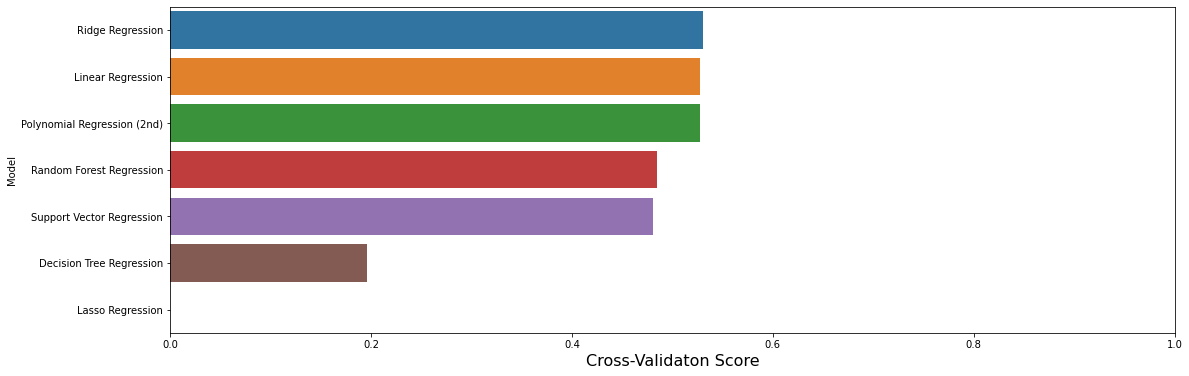

In [37]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['Cross-Validation'], ascending=False, inplace=True)

sns.barplot(x='Cross-Validation', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('Cross-Validaton Score', size=16)
axe.set_ylabel('Model')
axe.set_xlim(0,1.0)
plt.show()

(0.0, 1.0)

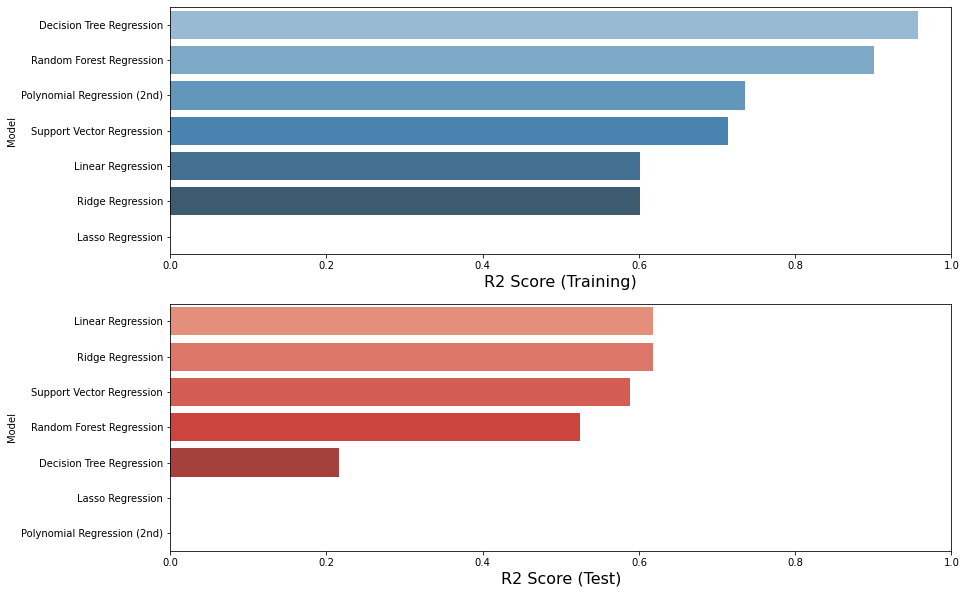

In [38]:
f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['R2_Score(training)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(training)', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('R2 Score (Training)', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)

predict.sort_values(by=['R2_Score(test)'], ascending=False, inplace=True)

sns.barplot(x='R2_Score(test)', y='Model', data = predict, palette='Reds_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('R2 Score (Test)', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)

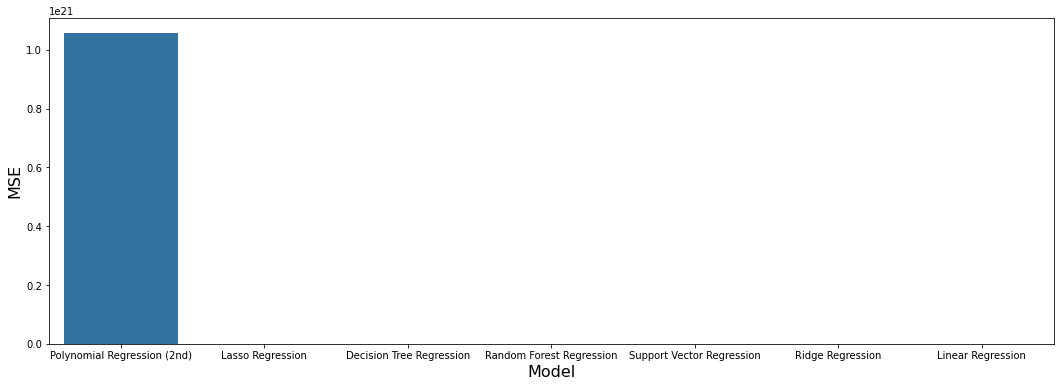

In [39]:
predict.sort_values(by=['MSE'], ascending=False, inplace=True)

f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='Model', y='MSE', data=predict, ax = axe)
axe.set_xlabel('Model', size=16)
axe.set_ylabel('MSE', size=16)

plt.show()

# Escala por Boxplot

<AxesSubplot:>

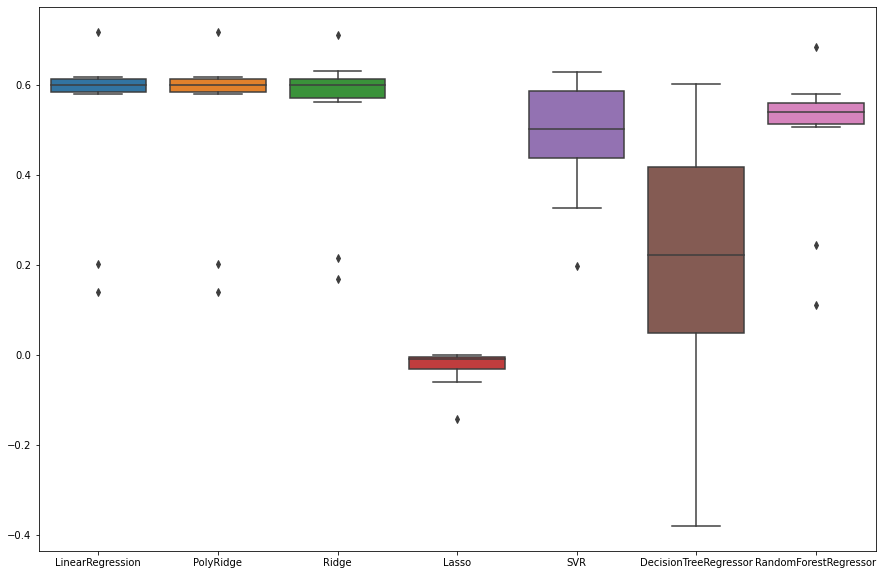

In [40]:
plt.figure(figsize=(15, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)